In [1]:
from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.datasets import ad_hoc_data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
# Definimos una semilla
seed = 667
algorithm_globals.random_seed = seed

## Importación de los datos del Titanic

In [3]:
# Importamos los datos del titanic tanto de entrenamiento como prueba y
# se imprime la infomración del set de datos de entrenamiento
train = pd.read_csv('data_titanic/train.csv')
test = pd.read_csv('data_titanic/test.csv')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Limpieza de los datos de entrenamiento

In [4]:
# La variable 'Embarked' tiene dos datos menos al total de datos, por lo que se
# elimina estos dos individuos de todo el conjunto de datos
train = train.dropna(subset=["Embarked"])

# Los datos que faltan de la variable 'Age' se rellenan con el promedio
# de los datos de dicha variable
mean = train["Age"].mean()
train["Age"] = train["Age"].fillna(mean)

# Eliminamos las variables que consideramos no aportan información en cuanto a 
# saber si el pasajero sobrevive o no
train = train.drop("Cabin", axis=1) 
train = train.drop("PassengerId", axis=1)
train = train.drop("Name", axis=1) 
train = train.drop("Ticket", axis=1) 

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


In [5]:
# observamos la información de los datos de prueba para conocer el tamaño del conjunto de datos
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


## Montaje y ejecución del circuito cuántico

In [6]:
feature_dim = 2  # Dimension of each data point
training_size = 889 # Dimension del conjunto de entrenamiento
test_size = 418 # Dimension del conjunto de prueba

In [7]:
# training_features, training_labels, test_features, test_labels como arreglos de numpy
training_features, training_labels, test_features, test_labels = \
    ad_hoc_data(
            training_size=training_size, test_size=test_size, n=feature_dim, gap=0.3)

In [8]:
# Mapa de caracteristicas usando ZZFeatureMap
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear")

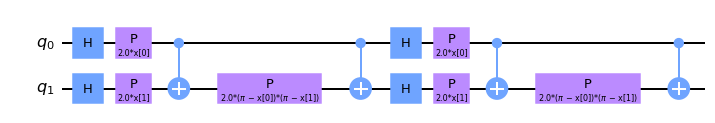

In [9]:
# Observamos el mapa de caracteristicas
display(feature_map.decompose().draw('mpl'))

In [10]:
# Aplicar la función TwoLocal sobre el mapa de caracteristicas
ansatz = TwoLocal(feature_map.num_qubits, ['ry', 'rz'], 'cz', reps=3)

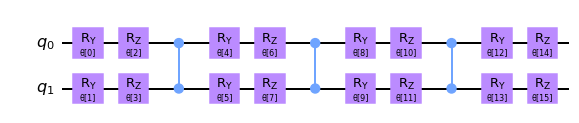

In [11]:
# Observamos el nuevo circuito despues de aplicar TwoLocal
display(ansatz.decompose().draw('mpl'))

In [12]:
# Funcion que dibuja un diagrama en tiempo de ejecución cuando se llama 
# el metodo de entrenamiento (.fit())
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [13]:
# Simulador del circuito cuántico
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), 
                                   shots=2048)

In [14]:
# Construcción del clasificador cuántico variacional usando SPSA como optimizador
vqc = VQC(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=SPSA(maxiter=9),
          quantum_instance=quantum_instance,
          callback=callback_graph
         )

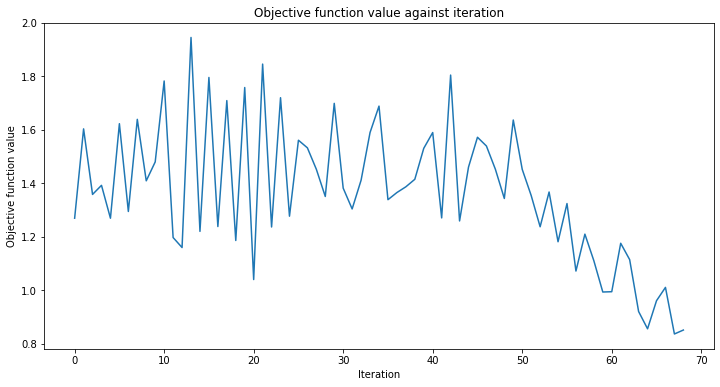

In [15]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# Entrenamiento del clasificador
#vqc.fit(X, y_one_hot)
vqc.fit(training_features, training_labels)

# Retornar el tamaño por defecto de la figura
# plt.rcParams["figure.figsize"] = (6, 4)

In [16]:
# Rendimiento del clasificador
#vqc.score(X, y_one_hot)
score = vqc.score(test_features, test_labels)
print(f"Testing accuracy: {score:0.2f}")

Testing accuracy: 0.66
